<a href="https://colab.research.google.com/github/sagarkumardse/Stock-Prediction/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction using Twitter sentiment analysis


In [ ]:
#while True:pass


KeyboardInterrupt: ignored

In [ ]:
!pip install yfinance tweepy
!pip install --upgrade pandas pandas-datareader
!pip install pandas --upgrade
!pip install emoji

In [ ]:
!pip install pyspark
!pip install findspark
!pip install -U -q PyDrive
!apt install openjdk-11-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

openjdk-11-jdk-headless is already the newest version (11.0.11+9-0ubuntu2~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
import os
from pathlib import Path

import re
import nltk
import emoji
import tweepy
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data
from wordcloud import WordCloud, STOPWORDS
from json import JSONDecoder, JSONDecodeError

nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
import warnings
import pyspark as ps
from pyspark.sql import SQLContext

In [ ]:
stocks = yf.download(tickers='AAPL', start='2014-01-01', end='2015-12-31', interval='1d')
stocks.reset_index(inplace=True)
stocks['Date'] = stocks['Date'].dt.strftime('%Y-%m-%d')
stocks

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.516609,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,17.131844,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.225258,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,17.102072,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,17.210381,258529600
...,...,...,...,...,...,...,...
498,2015-12-23,26.817499,27.212500,26.799999,27.152500,25.001883,130629600
499,2015-12-24,27.250000,27.250000,26.987499,27.007500,24.868372,54281600
500,2015-12-28,26.897499,26.922501,26.545000,26.705000,24.589830,106816800
501,2015-12-29,26.740000,27.357500,26.715000,27.184999,25.031809,123724800


In [ ]:
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

In [ ]:


def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ").replace(':',' ').replace("RT",' ') #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet


#draw a word cloud to for visulization
def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

In [ ]:

try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
data = pd.read_csv('/tweets_labelled_09042020_16072020.csv',delimiter = ";")
data = data[data['sentiment'].notna()]
data['text'] = data['text'].apply(lambda x: cleaner(x))

#print(data.text)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: SparkContext already exists in this scope
  


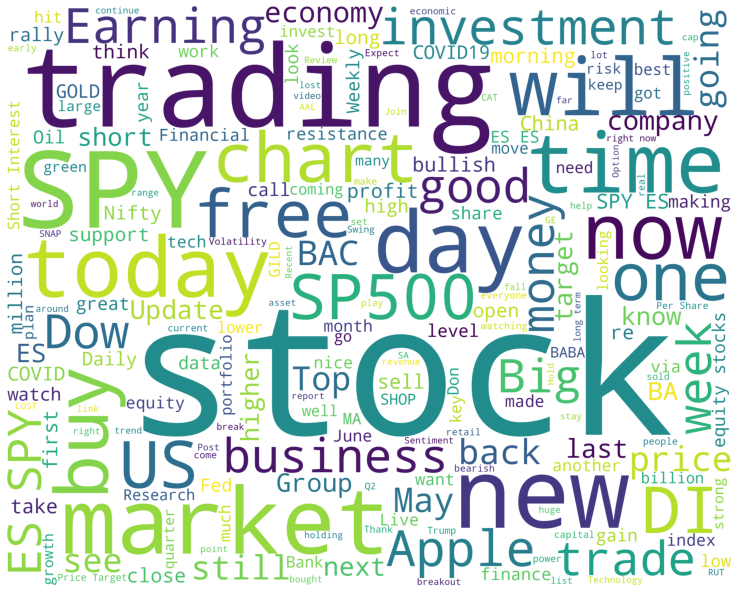

In [ ]:
features = get_word_features(list(data['text']))
wordcloud_draw(features)

In [ ]:
train = sqlContext.createDataFrame(data,["id","created_at",'text','sentiment'])

(train_set, val_set, test_set) = train.randomSplit([0.98, 0.01, 0.01], seed = 2000)


In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
test_df = pipelineFit.transform(test_set)
train_df.show(5)
val_df.show(5)

+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
|   id|          created_at|                text|sentiment|               words|                  tf|            features|label|
+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+-----+
| 1878|2020-04-09 20:17:...|Twitter to Share ...| positive|[twitter, to, sha...|(65536,[1512,1470...|(65536,[1512,1470...|  0.0|
| 7365|2020-04-09 14:26:...|$ SPY $ $ $ $ Tec...|  neutral|[$, spy, $, $, $,...|(65536,[10422,141...|(65536,[10422,141...|  1.0|
|11955|2020-04-09 05:58:...|This is not a fav...| negative|[this, is, not, a...|(65536,[1752,2035...|(65536,[1752,2035...|  2.0|
|14135|2020-04-09 00:00:...|$ target price is...| positive|[$, target, price...|(65536,[1124,2830...|(65536,[1124,2830...|  0.0|
|16588|2020-04-10 15:56:...|💥💥💥 administra...| negative|[💥💥💥, administ...|(65536,[4657,1009...|(6

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=200)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
test_predictions = lrModel.transform(test_df)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
ACC = evaluator.evaluate(predictions)
test_acc = evaluator.evaluate(test_predictions)
print("Accuracy Score for Validation data: {0:.4f}".format(ACC))
print("Accuracy Score for Test data: {0:.4f}".format(test_acc))


Accuracy Score for Validation data: 0.7143
Accuracy Score for Test data: 0.6154


In [ ]:
#Model 2 not used for final prediction

%%time
from pyspark.ml.feature import CountVectorizer

tokenizer = Tokenizer(inputCol="text", outputCol="words")
cv = CountVectorizer(vocabSize=2**16, inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
lr = LogisticRegression(maxIter=100)
pipeline = Pipeline(stages=[tokenizer, cv, idf, label_stringIdx, lr])

pipelineFit = pipeline.fit(train_set)
predictions = pipelineFit.transform(val_set)
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(val_set.count())
roc_auc = evaluator.evaluate(predictions)

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7857
ROC-AUC: 0.7857
CPU times: user 163 ms, sys: 26 ms, total: 189 ms
Wall time: 8.07 s


In [ ]:


dir='/AAPL'
# creat list of file names in directory dir 
date_wise=os.listdir(dir)
filtered = []

for i in date_wise:
    if i[0]!='.':
        filtered.append(i)
date_wise_file =[dir+'/' + file for file in filtered]
# returns JSON object as
# a dictionary
date_wise_tweet=[]
NOT_WHITESPACE = re.compile(r'[^\s]')
def decode_stacked(document, pos=0, decoder=JSONDecoder()):
    while True:
        match = NOT_WHITESPACE.search(document, pos)
        if not match:
            return
        pos = match.start()
        
        try:
            obj, pos = decoder.raw_decode(document, pos)
        except JSONDecodeError:
            # do something sensible if there's some error
            raise
        yield obj

for i in range(len(filtered)):
    s = ''  
    f = open(date_wise_file[i], "r")
    t = f.read()
    for obj in decode_stacked(t):
        temp = obj['text']
        s += ' '.join(temp)
        #tweets.append(s)
    a = date_wise[i].split('-')
    for p in range(3):
        a[p] = int(a[p])
    date_wise_tweet.append([date_wise[i], a[0], a[1], a[2],s])
    f.close()


In [ ]:
#date_wise_tweet

[['2014-02-02',
  2014,
  2,
  2,
  "top stocks today $ cboe $ iqnt $ vvc $ aapl give it a try URLrt AT_USER was the iphone 5c the cause of apple's woes ? apple won't say : URL $ aaplwsj : was the iphone 5c the cause of apple's woes ? apple won't say : URL $ aaplrt AT_USER triple digit returns from daytrades killer webinar URL $ aapl $ googrt AT_USER smartphone market share drops as samsung's edges up : URL $ aapl URLrt AT_USER apple's smartphone market share drops as samsung's edges up : URL $ aapl URLaapl ’ s pullback makes a perfect buying opportunity URL $ aaplthe $ aapl antitrust story URL$ aapl game changer coming in health industry this year ? might switch from AT_USER if you know me thatsaysalot URLrt AT_USER rt AT_USER open interest – february 7th expiration $ aapl $ amzn $ cmg $ fb $ goog $ nflx $ pcln $ tsla URLpull the trigger for triple digit returns on same day amazing webinar URL $ aapl $ goog$ aapl apple ’ s iphone sets student ’ s pants on fire URLAT_USER $ aapl used 1

In [ ]:
# join elements of text with space
test = sqlContext.createDataFrame(date_wise_tweet,["Date", "y", "m", "d","tweets"])
tokenizer = Tokenizer(inputCol="tweets", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
#label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

pipelineFit = pipeline.fit(test)
test= pipelineFit.transform(test)
test.show(5)


+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
|      Date|   y|  m|  d|              tweets|               words|                  tf|            features|
+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
|2014-02-02|2014|  2|  2|top stocks today ...|[top, stocks, tod...|(65536,[7,250,388...|(65536,[7,250,388...|
|2015-06-30|2015|  6| 30|aapl apple , inc ...|[aapl, apple, ,, ...|(65536,[19,231,10...|(65536,[19,231,10...|
|2015-09-04|2015|  9|  4|rt AT_USER apple ...|[rt, at_user, app...|(65536,[338,744,1...|(65536,[338,744,1...|
|2014-04-09|2014|  4|  9|$ aapl - comcast ...|[$, aapl, -, comc...|(65536,[367,559,6...|(65536,[367,559,6...|
|2015-03-04|2015|  3|  4|AT_USER i'd guess...|[at_user, i'd, gu...|(65536,[19,109,23...|(65536,[19,109,23...|
+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
only showi

In [ ]:
temp_pred = lrModel.transform(test)

In [ ]:
## import or load modules and packages
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.classification import MultilayerPerceptronClassifier as MPC
from pyspark.ml.feature import VectorAssembler as VA
from pyspark.ml.regression import * 
from pyspark.ml import *
from pyspark.sql import *
from pyspark.sql.functions import *
## instantiate spark session and context
spark = SparkSession.builder.getOrCreate()

In [ ]:
pred_rdd = temp_pred.rdd.map(lambda row: (row.Date, row.y, row.m, row.d, row.prediction, np.max(row.probability.toArray())))
pred_schema = pred_rdd.map(lambda t: Row(Date=t[0], y=t[1], m=t[2], d=t[3], prediction=t[4], probability=float(t[5])))
temp_pred = spark.createDataFrame(pred_schema)

In [ ]:
final_pred= temp_pred.toPandas()

"""
Index(['date', 'tweets', 'words', 'tf', 'features', 'rawPrediction',
       'probability', 'prediction'],
      dtype='object')
"""
print(final_pred[['prediction', 'probability']])

     prediction  probability
0           0.0     1.000000
1           0.0     0.992354
2           0.0     0.923196
3           0.0     1.000000
4           2.0     0.993418
..          ...          ...
691         0.0     0.802820
692         0.0     0.999956
693         0.0     1.000000
694         0.0     1.000000
695         0.0     1.000000

[696 rows x 2 columns]


In [ ]:
sdf = spark.createDataFrame(stocks)

In [ ]:
sdf.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [ ]:
class LagData:
  def __init__(self):
    self.nLags = 1 # default lag by 1 unit
    self.Features = []
    
  def setLag(self, nLags): # input integer lags
    self.nLags = nLags
    return self
  
  def setCols(self, col_names): # list of columns to lag
    self.columnNames = col_names
    return self
  
  def transform(self, df):
    for col in self.columnNames:
      df = df.withColumn("New_Col",lit(0))
      win = Window.orderBy("New_col")
      for i in range(self.nLags):
        strLag = col+'_LagBy_'+str(i+1)
        df = df.withColumn(strLag, lag(df[col], i+1).over(win)) 
        self.Features.append(strLag)
    df = df.drop("New_Col")
    return df
    
  def getFeatures(self):
    return self.Features

In [ ]:
#def Model(data, tweet_data, lag, target='Open'):
data = sdf
tweet_data = temp_pred
l = 2
target = 'Open'

new = data.join(tweet_data.select('Date', 'y', 'm', 'd', 'prediction', 'probability'), ['Date'])
new = new.orderBy(['y', 'm', 'd'])
LD = LagData().setCols(['Open', 'Close']).setLag(l)
tmp = LD.transform(new.select(['Open', 'Close', 'prediction', 'probability']))
cols = LD.getFeatures()
if(target=='Open'):
  c1 =  cols[0:l+2]
  c1.extend(['prediction', 'probability'])
## addressing two lags: Open and Closed, Hence two parameters
else:
  c2 = cols[0:1]+cols[l::]
  c1.extend(['prediction', 'probability'])
tmp = tmp.dropna()

va1 = VA().setInputCols(c1).setOutputCol("Data")
tmp1 = va1.transform(tmp)

lr = LinearRegression(featuresCol = "Data", predictionCol='stock_prediction', labelCol = target)
model = lr.fit(tmp1)
  #return model

In [ ]:
preds = model.transform(tmp1)
preds.select(['Open', 'stock_prediction']).show()
tmp = preds.toPandas()
np.sqrt(np.sum((tmp.Open - tmp.stock_prediction)**2))

+------------------+------------------+
|              Open|  stock_prediction|
+------------------+------------------+
|19.194643020629883|19.304286118383153|
|19.440000534057617|19.489976277310642|
|19.243213653564453|19.276002151081116|
|  19.5285701751709|19.433022091023307|
| 19.27964210510254| 19.12029520173179|
|18.925357818603516| 19.03430785287206|
|19.222143173217773|19.195526575313444|
|19.768571853637695|19.586279651590555|
| 19.81785774230957|19.957039224426726|
| 19.32107162475586|19.831851088826546|
|19.675357818603516|19.691261013643214|
|19.640714645385742|19.736907201545268|
| 19.78571319580078| 19.92863429175092|
|19.645357131958008|19.507571035873603|
|18.170000076293945|19.693448347462045|
|17.998214721679688|18.147699626769302|
|17.947856903076172| 17.90872370065005|
|17.684999465942383| 17.87202629932405|
| 17.95035743713379|17.907335518120245|
|18.066070556640625| 17.94441963199836|
+------------------+------------------+
only showing top 20 rows



6.741550805438052

##REAL TIME ANALYSIS 
Historical Data is accessed by yahoo finance api and date wise tweets are accessed by twitter api. The search parameters for the tweets are "Listed_name_of_company + Stock_exchange_name"

In [ ]:
#Live Twitter data streaming
import tweepy
import datetime
auth = tweepy.OAuthHandler('6OdM41Q84g0SMfj1S3WIzvCL7', '8SgA3kHXqZHZIyI8GfQvi54UN5FLkK0KyhH3Oc28T8j0zsV7RA')
auth.set_access_token('1288444504337391616-Nizzj1xufaikDHrQ3mud9rU0P4BUmO', 'BZEenDnVMYhESnonsrUjt61psBr5UloYf60wPemmgfo3n')

api = tweepy.API(auth,wait_on_rate_limit=True)
today = datetime.date.today()
end_day= today - datetime.timedelta(days=100) 
tweets_list = tweepy.Cursor(api.search, q="APPL+STOCK since:" + str(end_day)+ " until:" + str(today),tweet_mode='extended', lang='en').items()
output = []
for tweet in tweets_list:
    
    text = tweet._json["full_text"]
    if len(text)==0:
        text = 'none'
    #favourite_count = tweet.favorite_count
    #retweet_count = tweet.retweet_count
    created_at = tweet.created_at
    output.append([text,created_at.strftime('%Y-%m-%d')])
df = spark.createDataFrame(output,['tweets','date'])
df.show()

+--------------------+----------+
|              tweets|      date|
+--------------------+----------+
|If the $1422 was ...|2021-11-23|
|@ThePivotKing #MF...|2021-11-23|
|Today's #stock op...|2021-11-23|
|@Couzin_Vinny You...|2021-11-22|
|@KingMakerIQ @The...|2021-11-22|
|I almost went to ...|2021-11-22|
|$GTEC Market Cap ...|2021-11-22|
|@Dzungphil1 @Trad...|2021-11-22|
|RT @JosephHeatley...|2021-11-22|
|@Wildreamz @Luosh...|2021-11-22|
|RT @Turkish_007: ...|2021-11-21|
|What was your fir...|2021-11-21|
|@CashApp $bobbybr...|2021-11-20|
|@TCII_Blog @jason...|2021-11-20|
|@InvestiAnalyst 1...|2021-11-19|
|@erskinetimes Ifm...|2021-11-19|
|I used to think t...|2021-11-19|
|$MARA $RIOT $HUT ...|2021-11-19|
|.@ATT stock down ...|2021-11-19|
|Apple Fully Auton...|2021-11-19|
+--------------------+----------+
only showing top 20 rows



In [ ]:
temp  = df.rdd.map(lambda t:(t.date,t.tweets)).reduceByKey(lambda x,y:x+y)


In [ ]:
temp2 = temp.map(lambda d:(d[0],d[0].split('-'), d[1]))
live_rdd = temp2.map(lambda d:(d[0], d[1][0],d[1][1],d[1][2],d[2]) )
#live_rdd.take(2)

In [ ]:
live_schema = live_rdd.map(lambda t: Row(Date=t[0], y=t[1], m=t[2], d=t[3], tweets=t[4]))
live_pred_data = spark.createDataFrame(live_schema)
live_pipeline= pipelineFit.transform(live_pred_data)
live_pipeline.show(5)


+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
|      Date|   y|  m|  d|              tweets|               words|                  tf|            features|
+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
|2021-11-17|2021| 11| 17|time make 400 buc...|[time, make, 400,...|(65536,[1714,1880...|(65536,[1714,1880...|
|2021-11-16|2021| 11| 16|@wildace You buy ...|[@wildace, you, b...|(65536,[673,835,1...|(65536,[673,835,1...|
|2021-11-22|2021| 11| 22|@Couzin_Vinny You...|[@couzin_vinny, y...|(65536,[12,93,835...|(65536,[12,93,835...|
|2021-11-21|2021| 11| 21|RT @Turkish_007: ...|[rt, @turkish_007...|(65536,[4529,5222...|(65536,[4529,5222...|
|2021-11-15|2021| 11| 15|#MFAAANNGT \n$AMZ...|[#mfaaanngt, , $a...|(65536,[1981,2368...|(65536,[1981,2368...|
+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+
only showi

In [ ]:
live_pred = lrModel.transform(live_pipeline)
live_pred.show()

+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      Date|   y|  m|  d|              tweets|               words|                  tf|            features|       rawPrediction|         probability|prediction|
+----------+----+---+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|2021-11-17|2021| 11| 17|time make 400 buc...|[time, make, 400,...|(65536,[1714,1880...|(65536,[1714,1880...|[-1.8041661015931...|[0.03231358258219...|       2.0|
|2021-11-16|2021| 11| 16|@wildace You buy ...|[@wildace, you, b...|(65536,[673,835,1...|(65536,[673,835,1...|[2.59342818397340...|[0.80111121092644...|       0.0|
|2021-11-22|2021| 11| 22|@Couzin_Vinny You...|[@couzin_vinny, y...|(65536,[12,93,835...|(65536,[12,93,835...|[13.6410395909633...|[0.99999999620615...|       0.0|
|2021-11-21|2021| 11| 

In [ ]:
pred_rdd = live_pred.rdd.map(lambda row: (row.Date, row.y, row.m, row.d, row.prediction, np.max(row.probability.toArray())))
pred_schema = pred_rdd.map(lambda t: Row(Date=t[0], y=t[1], m=t[2], d=t[3], prediction=t[4], probability=float(t[5])))
live_pred = spark.createDataFrame(pred_schema)

In [ ]:
live_pred

DataFrame[Date: string, y: string, m: string, d: string, prediction: double, probability: double]

In [ ]:
live_stock = yf.download(tickers='AAPL', start='2021-11-15', end='2021-11-21', interval='1d')
live_stock.reset_index(inplace=True)
live_stock['Date'] = live_stock['Date'].dt.strftime('%Y-%m-%d')
live_stocks = spark.createDataFrame(live_stock)

[*********************100%***********************]  1 of 1 completed


In [ ]:
live_new = live_stocks.join(live_pred.select('Date', 'y', 'm', 'd', 'prediction', 'probability'), ['Date'])
live_new = live_new.orderBy(['y', 'm', 'd'])
LD1 = LagData().setCols(['Open', 'Close']).setLag(l)
live_feed = LD1.transform(live_new.select(['Open', 'Close', 'prediction', 'probability']))
cols = LD1.getFeatures()
if(target=='Open'):
  c1 =  cols[0:l+2]
  c1.extend(['prediction', 'probability'])
## addressing two lags: Open and Closed, Hence two parameters
else:
  c2 = cols[0:1]+cols[l::]
  c1.extend(['prediction', 'probability'])
live_feed = live_feed.dropna()

va2 = VA().setInputCols(c1).setOutputCol("Data")
live_feed = va2.transform(live_feed)

In [ ]:
p = model.transform(live_feed)
p.select([target, 'stock_prediction']).show()
p = p.toPandas()
np.sqrt(np.sum((p.Open - p.stock_prediction)**2))

+------------------+------------------+
|              Open|  stock_prediction|
+------------------+------------------+
|             151.0|151.06976382227552|
| 153.7100067138672|153.74207359631166|
|157.64999389648438|158.36874371933487|
+------------------+------------------+



0.7228392516291707